In [603]:
#Calculon post processing

In [ ]:
resultsDir = "testRuns"
simListFile = f"{resultsDir}/simRuns.txt"
SHARE_DIR = "/imec/other/dtpatha/patel23/share/calculon"


In [598]:
import sys

!{sys.executable} -m pip install "numpy<2.0" pandas matplotlib seaborn scipy iosort --user


The following have been reloaded with a version change:
  1) devel/ncurses/6.5 => devel/ncurses/6.2-GCCcore-11.2.0

Lmod has detected the following error:  Unable to load module
because of error when evaluating modulefile:
     /imec/other/pathfind/modules/pathfind/conda/current.lua: [string
"help("Load conda and mamba for the pathfind environment")..."]:8: attempt to
call a nil value (global 'source_sh')
     Please check the modulefile and especially if there is a the line number
specified in the above message 
While processing the following module(s):
    Module fullname         Module Filename
    ---------------         ---------------
    pathfind/conda/current  /imec/other/pathfind/modules/pathfind/conda/current.lua

ERROR: Could not find a version that satisfies the requirement iosort (from versions: none)
ERROR: No matching distribution found for iosort


In [136]:
import matplotlib.pyplot as plt

import os, os.path
import json
import csv
import shutil
import pandas as pd

import seaborn as sns

from Loader import Loader

In [7]:
# Loading lsit of simulations that were done
simRuns = []
with open(f"{simListFile}", "r") as file:
    simRuns = file.readlines()

_data = []
for cSim in simRuns:
    #systemPath = cSim.split("/")[-1]
    systemPath = cSim.replace(".json", "")
    systemPath = systemPath.replace("\n", "")

    splitStr = systemPath.split("_")
    try:
        cData = {
            "Sim": systemPath,
            "System": splitStr[0] + "_" + splitStr[1],
            "Memory": splitStr[2],
            "Mem Capacity": splitStr[3],
            "Mem BW": splitStr[4],
            "IntraChiplet": splitStr[5],
            "IntraChiplet BW": splitStr[6],
            "IntraChiplet Eff": splitStr[7],
            "InterChiplet": splitStr[8],
            "InterChiplet BW": splitStr[9],
            "InterChiplet Eff": splitStr[10],
        }

        statFile = resultsDir + "/loe/" + systemPath + ".json"
        # print(statFile)

        with open(statFile, mode="r", encoding="utf-8") as read_file:
            jsonObj = json.load(read_file)
            for key, value in jsonObj["0"]["stats"].items():
                cData[key] = value
            cData["SysConfig"] = {}
            for key, value in jsonObj["0"]["stats"].items():
                cData[key] = value

        _data.append(cData)
    except Exception as e:
        print("Simething was off ...")
        print(e)    
    
    
    # loader.stop()
pd_results = pd.DataFrame(_data)

In [51]:
print(pd_results.columns.tolist())

['Sim', 'System', 'Memory', 'Mem Capacity', 'Mem BW', 'IntraChiplet', 'IntraChiplet BW', 'IntraChiplet Eff', 'InterChiplet', 'InterChiplet BW', 'InterChiplet Eff', 'block_fw_flops', 'block_fw_flops_time', 'block_fw_mem_accessed', 'block_fw_mem_time', 'block_fw_time', 'baseblock_fw_tp_time', 'edgeblock_fw_tp_time', 'baseblock_fw_tp_time_exposed', 'edgeblock_fw_tp_time_exposed', 'block_re_flops', 'block_re_flops_time', 'block_re_mem_accessed', 'block_re_mem_time', 'block_re_time', 'baseblock_recomm_time', 'edgeblock_recomm_time', 'baseblock_recomm_time_exposed', 'edgeblock_recomm_time_exposed', 'block_agrad_flops', 'block_agrad_flops_time', 'block_agrad_mem_accessed', 'block_agrad_mem_time', 'block_agrad_time', 'baseblock_agrad_tp_time', 'edgeblock_agrad_tp_time', 'baseblock_agrad_tp_time_exposed', 'edgeblock_agrad_tp_time_exposed', 'block_wgrad_flops', 'block_wgrad_flops_time', 'block_wgrad_mem_accessed', 'block_wgrad_mem_time', 'block_wgrad_time', 'block_optim_flops', 'block_optim_flop

In [600]:
print(pd_results["Memory"].unique())
print(pd_results["Mem Capacity"].unique())
print(pd_results["IntraChiplet"].unique())
print(pd_results["InterChiplet"].unique())
print(pd_results.dtypes["Mem Capacity"])

configuredMemCapacity = {"HBM2e": 16, "HBM3": 24, "HBM4": 36, "HBM5":48}

def returnStacks(memType):
    return int(configuredMemCapacity[memType])

pd_results["Cap per chiplet"] = pd_results["Memory"].map(returnStacks)
pd_results["Mem per chiplet"] = pd_results["Mem Capacity"].astype(int) / pd_results["Cap per chiplet"].astype(int)
    
print(pd_results["Mem per chiplet"].unique())
print(pd_results.dtypes["Mem per chiplet"])

flopRelatedRes = ['Memory']
timeRelatedRes = []
generalTimeRes = []
memAccessRelatedRes = [
  'Memory']
capRequire = ['Memory']
bwRequire= []
totalTime = ["total_time"]
efficiency = []
intraLinks = pd_results["IntraChiplet"].unique()
interLinks = pd_results["InterChiplet"].unique()
memSpace = ['Memory']
memSpaceOffload = ['Memory']


for _cres in pd_results.columns.tolist():
    if "flop" in _cres and not("time" in _cres) and not("useful" in _cres):
        flopRelatedRes.append(_cres)
    if "time" in _cres and not("total" in _cres):
        timeRelatedRes.append(_cres)
    if "req" in _cres and "cap" in _cres:
        capRequire.append(_cres)
    if "req" in _cres and "bw" in _cres:
        bwRequire.append(_cres)
    if "eff" in _cres:
        efficiency.append(_cres)
    if "access" in _cres:
        memAccessRelatedRes.append(_cres)
    if "space" in _cres  and not("with" in _cres) and not("block" in _cres):
        memSpace.append(_cres)
    if "space" in _cres  and ("with" in _cres) and not("block" in _cres):
        memSpaceOffload.append(_cres)

new_total_time = [
  'Memory',
 'fw_time', 
 'bw_time', 
 'optim_step_time', 
 'recompute_time', 
 'recomm_exposed_time', 
 'bubble_time', 
 'tp_comm_exposed_time', 
 'pp_comm_exposed_time', 
 'dp_comm_exposed_time', 
 'fw_offload_exposed_time', 
 'bw_offload_exposed_time']
 
detail_total_time = [
    'Memory',
    'block_fw_time', 
    'baseblock_fw_tp_time', 
    'edgeblock_fw_tp_time', 
    'block_re_time',
    'baseblock_recomm_time', 
    'edgeblock_recomm_time',
    'block_agrad_time', 
    'baseblock_agrad_tp_time', 
    'edgeblock_agrad_tp_time',
    'block_wgrad_time', 
    'block_optim_time']
 
comm_time = [
  'Memory',
 'tp_comm_link_time', 
 'pp_comm_link_time', 
 'dp_comm_link_time']
 
compute_time = [
'Memory',
 'block_fw_flops_time', 
 'block_re_flops_time', 
 'block_agrad_flops_time', 
  'block_wgrad_flops_time', 
  'block_optim_flops_time']
    
memory_time = [
    'Memory',
 'block_fw_mem_time', 
 'block_re_mem_time', 
 'block_agrad_mem_time', 
 'block_wgrad_mem_time', 
 'block_optim_mem_time']

    
print(flopRelatedRes)
print(timeRelatedRes)
print(capRequire)
print(bwRequire)
print(efficiency)
print(memAccessRelatedRes)
print(memSpace)
print(memSpaceOffload)

['HBM2e' 'HBM3' 'HBM4' 'HBM5']
['64' '128' '192' '96' '144' '288' '384']
['NVLink-C2C' 'NVLink-HBI' 'NVLink3' 'NVLink4' 'NVLink5' 'NVLink6'
 'UCIe-4' 'UCIe-8' 'UCIe-16' 'UCIe-32' 'UCIe-48' 'UCIe-64' 'UCIe-128']
['NVLink-C2C' 'NVLink-HBI' 'NVLink3' 'NVLink4' 'NVLink5' 'NVLink6'
 'UCIe-4' 'UCIe-8' 'UCIe-16' 'UCIe-32' 'UCIe-48' 'UCIe-64' 'UCIe-128']
object
[ 4.  8. 12.]
float64
['Memory', 'block_fw_flops', 'block_re_flops', 'block_agrad_flops', 'block_wgrad_flops', 'block_optim_flops']
['block_fw_flops_time', 'block_fw_mem_time', 'block_fw_time', 'baseblock_fw_tp_time', 'edgeblock_fw_tp_time', 'baseblock_fw_tp_time_exposed', 'edgeblock_fw_tp_time_exposed', 'block_re_flops_time', 'block_re_mem_time', 'block_re_time', 'baseblock_recomm_time', 'edgeblock_recomm_time', 'baseblock_recomm_time_exposed', 'edgeblock_recomm_time_exposed', 'block_agrad_flops_time', 'block_agrad_mem_time', 'block_agrad_time', 'baseblock_agrad_tp_time', 'edgeblock_agrad_tp_time', 'baseblock_agrad_tp_time_exposed', 'e

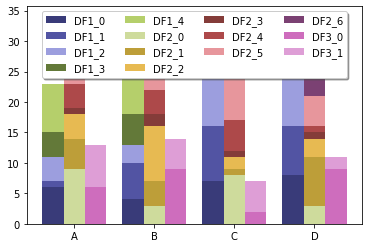

In [592]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

def plot_stacked_clustered_bar(*dfs2, ax=None, group_labels=None, index_col=None, index_labels=None, cmap_name='tab20b'):
    if group_labels is None:
        group_labels = [f'Group{i+1}' for i in range(len(dfs2))]
        
    # Ensure all dataframes contain the index_col if specified
    if index_col:
        dfs = [df.set_index(index_col) if index_col in df.columns else df for df in dfs2]

    # Align dataframes on the index
    common_index = dfs[0].index
    for df in dfs[1:]:
        common_index = common_index.intersection(df.index)
    dfs = [df.loc[common_index] for df in dfs]

    n_rows = len(common_index)
    index_labels = common_index.tolist()

    # Prepare dataframes with multiindex
    multi_col_dfs = []
    for df, label in zip(dfs, group_labels):
        df.columns = pd.MultiIndex.from_product([[label], df.columns])
        multi_col_dfs.append(df)

    df_all = pd.concat(multi_col_dfs, axis=1)

    # Plot settings
    n_groups = len(group_labels)
    bar_width = 0.8 / n_groups
    x = np.arange(n_rows)

    # Color map
    cmap = cm.get_cmap(cmap_name)
    colors = cmap(np.linspace(0, 1, sum(df.shape[1] for df in dfs)))
    color_idx = 0

    legend_dict = {label: [] for label in group_labels}
    legend_list = []

    for i, (group_name, group_df) in enumerate(df_all.groupby(level=0, axis=1)):
        bottom = np.zeros(n_rows)
        for col in group_df.columns:
            y = group_df[col].values
            color = colors[color_idx]
            ax.bar(
                x + i * bar_width, 
                y, 
                bar_width, 
                bottom=bottom, 
                color=color
            )
            legend_dict[group_name].append(Patch(facecolor=color, label=col[1]))
            legend_list.append(col[1])
            bottom += y
            color_idx += 1

    ax.set_xticks(x + bar_width * (n_groups - 1) / 2)
    ax.set_xticklabels(index_labels)
    ax.legend(legend_list, loc='upper center', bbox_to_anchor=(0.5, 1.0),
          fancybox=True, shadow=True, ncol=4)

    # Create separate legend blocks
    #legend_x = 1.05
    #for i, (group, patches) in enumerate(legend_dict.items()):
    #    ax.legend(handles=patches, title=group, bbox_to_anchor=(legend_x, 1 - i * 0.3), loc='upper left')


# Example usage
fig, _plt = plt.subplots()
np.random.seed(0)
df1 = pd.DataFrame(np.random.randint(1, 10, (4, 5)), columns=[f'DF1_{i}' for i in range(5)])
df2 = pd.DataFrame(np.random.randint(1, 10, (4, 7)), columns=[f'DF2_{i}' for i in range(7)])
df3 = pd.DataFrame(np.random.randint(1, 10, (4, 2)), columns=[f'DF3_{i}' for i in range(2)])

# Add a common column to use as index
df1['Category'] = ['A', 'B', 'C', 'D']
df2['Category'] = ['A', 'B', 'C', 'D']
df3['Category'] = ['A', 'B', 'C', 'D']

plot_stacked_clustered_bar(df1, df2, df3, ax=_plt, group_labels=['First', 'Second', 'Third'], index_col='Category')
plt.show()

<Figure size 432x288 with 0 Axes>

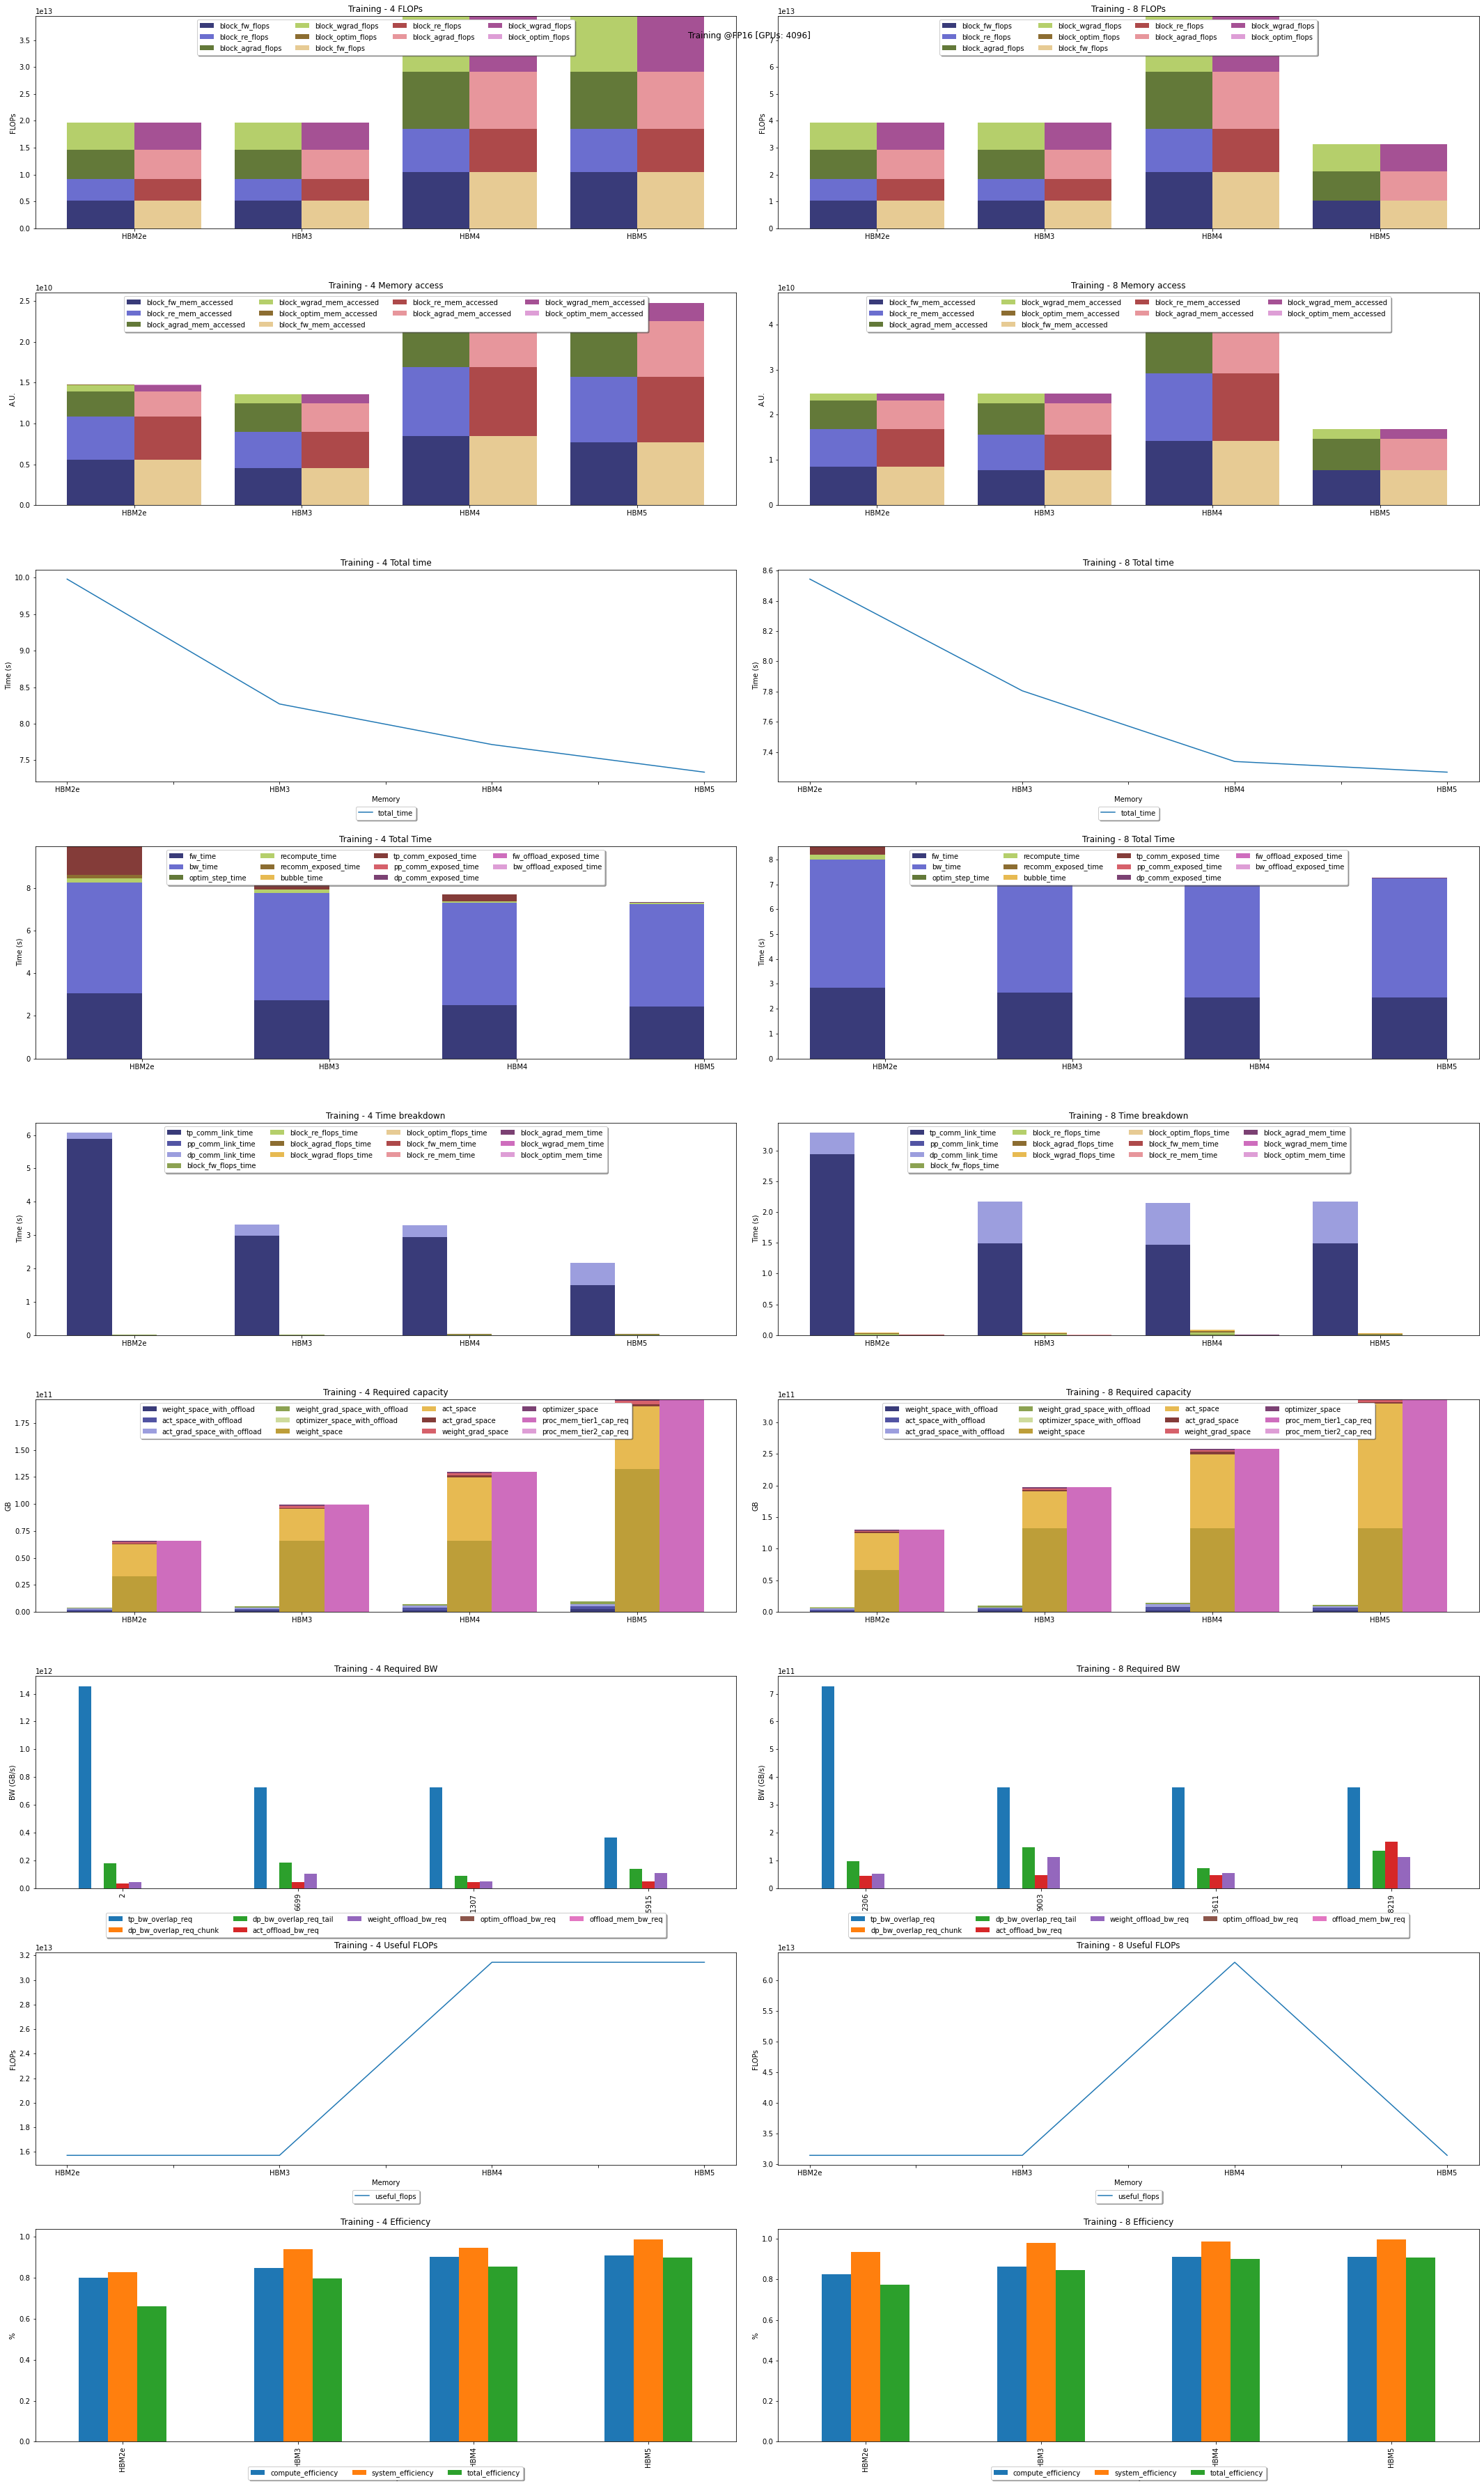

In [602]:
#  HBM scaling with different interconnects
_stacks = {}
x = 0

plt.figure()
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(30, 50))#, sharey='row')#, sharex='col')#,sharex=True)

interNode = "NVLink3"
intraNode = "NVLink-C2C"

nvl3 = "NVLink3"
nvl4 = "NVLink4"
nvl5 = "NVLink5"
nvl_c2c = "NVLink-C2C"

# Collecting data in dicts _stacks[4,8,12,16]["Training"][InterNode][IntraNode]
for _cStack in [4, 8]:#, 12]:

    _stacks[_cStack] = {}
    _stacks[_cStack]["Training"] = pd_results[pd_results['Mem per chiplet'] == _cStack]
    
    for _interLink in interLinks:
        _tmpIntra = _stacks[_cStack]["Training"][_stacks[_cStack]["Training"]['InterChiplet'] == _interLink]
        _stacks[_cStack][_interLink] = {}
        for _intraLink in intraLinks:
            _stacks[_cStack][_interLink][_intraLink] = {}
            for _cIntra in intraLinks:
                if _intraLink in _cIntra:
                    _stacks[_cStack][_interLink][_intraLink] = _tmpIntra[_tmpIntra["IntraChiplet"] == _intraLink]

for _cStack in [4, 8]:#, 12]:
    r = 0
    
    # FLOPs
    _plt = ax[r, x]
    plot_stacked_clustered_bar(
            _stacks[_cStack][nvl3][nvl3][flopRelatedRes], 
            _stacks[_cStack][nvl3][nvl_c2c][flopRelatedRes],
            ax=_plt, 
           group_labels=['NVLink3-NVLink3', 'NVLink3-NVLink-C2C'], 
           index_labels=_stacks[_cStack][interNode][intraNode]["Memory"].unique(), index_col='Memory'
    )
    _plt.set_title(f"{sim} - {_cStack} FLOPs")
    _plt.set_ylabel("FLOPs")

    r += 1
    
    # Mem Access clustered bar plot
    _plt = ax[r, x]
    #_stacks[_cStack][interNode][intraNode].plot(ax=_plt, x="Memory", y=memAccessRelatedRes, kind="bar")
    plot_stacked_clustered_bar(
            _stacks[_cStack][nvl3][nvl3][memAccessRelatedRes], 
            _stacks[_cStack][nvl3][nvl_c2c][memAccessRelatedRes],
            ax=_plt, 
           group_labels=['NVLink3-NVLink3', 'NVLink3-NVLink-C2C'], 
           index_labels=_stacks[_cStack][interNode][intraNode]["Memory"].unique(), index_col='Memory'
    )
    _plt.set_title(f"{sim} - {_cStack} Memory access")
    _plt.set_ylabel("A.U.")
    r += 1
    
    # Total time
    _plt = ax[r, x]
    _stacks[_cStack][interNode][intraNode].plot(ax=_plt, x="Memory", y=totalTime)
    _plt.set_title(f"{sim} - {_cStack} Total time")
    _plt.set_ylabel("Time (s)")
    _plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
    _plt.yaxis.set_tick_params(labelleft=True)
    r += 1
    
    # Total stacked + clustered bar plot
    _plt = ax[r, x]
    plot_stacked_clustered_bar(
            _stacks[_cStack][interNode][intraNode][new_total_time], 
            #_stacks[_cStack][interNode][intraNode][detail_total_time] * 210, 
        ax=_plt, 
       group_labels=['First', 'Second'], 
       index_labels=_stacks[_cStack][interNode][intraNode]["Memory"].unique(), index_col='Memory'
    )
    _plt.set_title(f"{sim} - {_cStack} Total Time")
    _plt.set_ylabel("Time (s)")
    _plt.yaxis.set_tick_params(labelleft=True)
    r += 1
    
    # Compute, mem and interconnect stacked + clustered bar plot
    _plt = ax[r, x]
    plot_stacked_clustered_bar(_stacks[_cStack][interNode][intraNode][comm_time], 
                                _stacks[_cStack][interNode][intraNode][compute_time], 
                                _stacks[_cStack][interNode][intraNode][memory_time], 
                               ax=_plt, 
                               group_labels=['First', 'Second', 'Third'], 
                               index_labels=_stacks[_cStack][interNode][intraNode]["Memory"].unique(), index_col='Memory'
                              )

    _plt.set_title(f"{sim} - {_cStack} Time breakdown")
    _plt.set_ylabel("Time (s)")
    _plt.yaxis.set_tick_params(labelleft=True)
    r += 1
    
    # Cap rquirement stacked bar plot
    _plt = ax[r, x]
    plot_stacked_clustered_bar(
            _stacks[_cStack][interNode][intraNode][memSpaceOffload],
            _stacks[_cStack][interNode][intraNode][memSpace],
            _stacks[_cStack][interNode][intraNode][capRequire], 
            ax=_plt, 
           group_labels=['First', 'Second', 'Third'], 
           index_labels=_stacks[_cStack][interNode][intraNode]["Memory"].unique(), index_col='Memory'
    )    
    #_stacks[_cStack][interNode][intraNode].plot(ax=_plt, x="Memory", y=capRequire, kind='bar', stacked=True)
    _plt.set_title(f"{sim} - {_cStack} Required capacity")
    _plt.set_ylabel("GB")
    _plt.yaxis.set_tick_params(labelleft=True)
    r += 1
    
    # BW requirment clustered bar plot
    _plt = ax[r, x]
    #for _col in bwRequire:
    #    _stacks[_cStack][interNode][intraNode][_col] = _stacks[_cStack][interNode][intraNode][_col].astype(int) / (1024 * 1024 * 1024)
    _stacks[_cStack][interNode][intraNode].plot(ax=_plt, y=bwRequire, kind="bar")
    _plt.set_title(f"{sim} - {_cStack} Required BW")
    _plt.set_ylabel("BW (GB/s)")
    _plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
    _plt.yaxis.set_tick_params(labelleft=True)
    r += 1
    
    # Useful flops
    _plt = ax[r, x]
    _stacks[_cStack][interNode][intraNode].plot(ax=_plt, x="Memory", y=['useful_flops'])
    _plt.set_title(f"{sim} - {_cStack} Useful FLOPs")
    _plt.set_ylabel("FLOPs")
    _plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
    _plt.yaxis.set_tick_params(labelleft=True)
    r += 1
    
    # Efficiency clustered bar plot
    _plt = ax[r, x]
    _stacks[_cStack][interNode][intraNode].plot(ax=_plt, x="Memory", y=efficiency, kind="bar")
    _plt.set_title(f"{sim} - {_cStack} Efficiency")
    _plt.set_ylabel("%")
    _plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
    _plt.yaxis.set_tick_params(labelleft=True)
    r += 1
    
    x += 1

fig.suptitle(f"Training @FP16 [GPUs: 4096]")    
fig.tight_layout()
plt.show()


In [ ]:
scipy.io.savemat(f'{resultsDir}/Inference.mat', {'Prefill':pd_prefill.to_dict("list"), "Generation": pd_generation.to_dict("list")})

with open(f"{resultsDir}/prefill.csv", "w", newline="") as csvfile:
    fieldnames = initList[0].keys()
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(initList)
    
with open(f"{resultsDir}/generation.csv", "w", newline="") as csvfile:
    fieldnames = ar_list[0].keys()
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(ar_list)

In [ ]:
# Optional for sharing of csvs
shutil.copy(f'{resultsDir}/Inference.mat', f'{SHARE_DIR}/Inference.mat')

destFile = f"{SHARE_DIR}/prefill.csv"
shutil.copy(f"{resultsDir}/prefill.csv", destFile)

destFile = f"{SHARE_DIR}/generation.csv"
shutil.copy(f"{resultsDir}/generation.csv", destFile)